<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/BCC_Calibration_Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **Bakshi, Cao, and Chen (BCC '97)** model is a comprehensive option pricing framework that seamlessly integrates the stochastic volatility attributes of the Heston 1993 (H93) model with the jump diffusion aspects of the Merton 1976 (M76) model. A distinguishing hallmark of the BCC model is its introduction of correlated jumps in volatility.

The model's characteristic function is a product of the H93 and M76 functions, with further modifications for volatility jumps. Specifically:

$
\Phi_{\text{BCC}}(u) = \Phi_{\text{H93}}(u) \times \Phi_{\text{M76}}(u) \times e^{\rho_J \lambda (\exp(i u \mu_V \delta_V) - 1) T}
$

This function encompasses intricate mathematical relations and parameters, capturing the complexities of the option pricing environment.

Diving deeper:

1. **BCC Model**: A fusion of the H93's stochastic volatility and M76's asset price jumps, it also uniquely considers correlated volatility jumps.
2. **H93 Model**: Represents stochastic volatility through a square-root diffusion process, akin to the Cox-Ingersoll-Ross interest rate model. It encapsulates parameters like the speed of adjustment ($ \kappa_v $), the long-term mean variance ($\theta_v $), the volatility's variance ($ \sigma_v $), and the correlation between the asset price and its variance ($ \rho $).
3. **M76 Model**: Deals with the jump diffusion component, positing that asset prices can experience jumps at any moment. This model evaluates the jump intensity ($\lambda $), expected jump magnitude ($ \mu $), and the jump size's standard deviation ($ \delta $).
4. **Jumps in Volatility**: This innovative aspect introduces parameters such as $\mu_V $ (expected volatility jump size), $\delta_V $ (standard deviation of the volatility jump size), and $ \rho_J $ (correlation between asset price jumps and its volatility).
5. **Objective Function**: Seeks to minimize the squared differences between model and market prices, aiding in model calibration.
6. **Calibration**: Utilizes optimization techniques on market data to minimize discrepancies between market and model option prices.

Furthermore, the BCC model is characterized by:

1. **Stock Price $( S_t $)**: The current underlying stock price.
2. **Volatility ($\sigma_t $)**: The stock's stochastic instantaneous volatility.
3. **Risk-free Rate ($r_t $)**: A stochastic instantaneous risk-free rate that follows a mean-reverting trajectory.
4. **Jump Intensity ($ \lambda $)**: Governs the stock price's jump frequency.
5. **Mean Reversion Speed ($ \kappa $)**: The rate at which stochastic interest or volatility reverts to its long-term mean.
6. **Correlations**: Potential correlations among multiple stochastic processes such as stock price, volatility, and interest rate.

In essence, the BCC model is a robust mathematical instrument adept at capturing the multifaceted dynamics of option pricing, including stochastic volatility, asset price jumps, and even stochastic interest rates. Its depth allows it to emulate a vast spectrum of market scenarios. However, its complexity necessitates advanced numerical methods for real-world option pricing, making it a more demanding alternative to simpler models like Black-Scholes.

**Tools and Techniques**

1. **Characteristic Functions**: These functions are central to the Fourier-based option pricing technique employed in the model.
2. **Numerical Integration**: Specifically, the `quad` function from `scipy.integrate` is used to evaluate integrals, a key part of the Fourier-based approach.
3. **Optimization Techniques**: The `minimize` function from `scipy.optimize` is used to calibrate the model parameters based on market data.
4. **Pandas and NumPy**: Used for efficient data handling and numerical operations.
5. **Numba's `njit` Decorator**: Used to speed up numerical computations by just-in-time compilation.

**Strengths**
1. **Comprehensive Modeling**: The BCC model integrates stochastic volatility, asset price jumps, and jumps in volatility, allowing it to capture a wide variety of market behaviors.
2. **Flexible**: The model can emulate a vast spectrum of market scenarios through its many parameters.
3. **Correlation Handling**: The BCC model is notable for considering the correlation between asset price jumps and volatility jumps, a feature lacking in many simpler models.

**Weaknesses**
1. **Complexity**: The model involves complex mathematical equations and multiple parameters, making it computationally intensive and challenging to understand and implement.
2. **Calibration Challenge**: The model requires a significant amount of market data for calibration, and finding the optimal parameters can be computationally demanding.
3. **Risk of Overfitting**: Due to its many parameters, the model might overfit to the calibration data, which may lead to poor out-of-sample performance.

**Areas for Improvement**
1. **Computational Efficiency**: The model's computations, especially during calibration, can be computationally intensive. Optimizing the code for better performance, possibly through parallelization or more efficient algorithms, could be beneficial.
2. **Parameter Stability**: Introducing constraints or penalties in the optimization process might lead to more stable and realistic parameter estimates.
3. **Model Validation and Testing**: The implementation could benefit from extensive testing against known benchmarks or market data to validate its accuracy and reliability under various market conditions.


In [ ]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

# Defining the required functions for the BCC model
# Valuation of European Call and Put Options
# Under Stochastic Volatility, Jumps and Correlated Jumps in Volatility
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python

@njit
def BCC_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ):
    ''' Valuation of European call option in BCC97 model via Lewis (2001)
    Fourier-based approach: characteristic function.'''
    BCC1 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return BCC1 * BCC2 * np.exp(rhoJ * jumpVolatilityPart)

@njit
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.'''
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v)
                  ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) \
        / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r * u * 1j * T + (c1 / sigma_v ** 2)
          * ((kappa_v - rho * sigma_v * u * 1j + c2) * T
             - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2
          * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

@njit
def M76_char_func(u, T, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via Lewis (2001)
    Fourier-based approach: characteristic function.'''
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb
                              * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

@njit
def BCC_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ):
    ''' Valuation of European call option in BCC97 model via Lewis (2001)
    Fourier-based approach: integration function.'''
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) \
        * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

def BCC_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ):
    ''' Valuation of European call option in BCC97 model via Lewis (2001)
    Fourier-based approach.'''
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def BCC_put_value(C, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ):
    ''' Valuation of European put option in BCC97 model via Lewis (2001)
    Fourier-based approach.'''
    C = BCC_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ)
    put_value = C + K * np.exp(-r * T) - S0
    return put_value

# File Processing and Parameter Calibration
file_path = 'sorted_options_data.csv'
options_data_bcc_SLSQP = pd.read_csv(file_path)
options_data_bcc_SLSQP = options_data_bcc_SLSQP.iloc[1:]
options_data_bcc_SLSQP['T'] = (pd.to_datetime(options_data_bcc_SLSQP['EXPIR_DATE']) - pd.to_datetime(options_data_bcc_SLSQP['CF_DATE'])).dt.days / 365.25

r = -0.5

def objective(params, option_type):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data_bcc_SLSQP.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0, lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

initial_params = [1.5, 0.02, 0.15, 0.1, 0.01, 0.25, -0.2, 0.1, 0.1, 0.1, 0.1]  # kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ
bounds = [(0, 5), (0, 0.5), (0, 1), (-1, 1), (0, 1), (0, 1), (-1, 1), (0, 1), (0, 1), (0, 1), (-1, 1)]  # Constraints for all parameters

def process_batch(imp_volt_range, options_data_bcc_SLSQP):
    options_data_bcc_SLSQP['IMP_VOLT_RANGE'] = options_data_bcc_SLSQP['IMP_VOLT'].apply(lambda x: int(x))
    options_in_range = options_data_bcc_SLSQP[options_data_bcc_SLSQP['IMP_VOLT_RANGE'] == imp_volt_range]

    if options_in_range.empty:
        print(f"No options found in implied volatility range {imp_volt_range}")
        return options_in_range, None, None

    result_call = minimize(lambda x: objective(x, 'CALL'), initial_params, bounds=bounds, method='SLSQP')
    kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call, lamb_call, mu_call, delta_call, muV_call, deltaV_call, rhoJ_call = result_call.x
    print(f"Calibrated Parameters for CALL options in group {imp_volt_range}:")
    print("Kappa_v:", kappa_v_call)
    print("Theta_v:", theta_v_call)
    print("Sigma_v:", sigma_v_call)
    print("Rho:", rho_call)
    print("V0:", v0_call)
    print("Lamb:", lamb_call)
    print("Mu:", mu_call)
    print("Delta:", delta_call)
    print("MuV:", muV_call)
    print("DeltaV:", deltaV_call)
    print("RhoJ:", rhoJ_call)

    result_put = minimize(lambda x: objective(x, 'PUT'), initial_params, bounds=bounds, method='SLSQP')
    kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put, lamb_put, mu_put, delta_put, muV_put, deltaV_put, rhoJ_put = result_put.x
    print(f"Calibrated Parameters for PUT options in group {imp_volt_range}:")
    print("Kappa_v:", kappa_v_put)
    print("Theta_v:", theta_v_put)
    print("Sigma_v:", sigma_v_put)
    print("Rho:", rho_put)
    print("V0:", v0_put)
    print("Lamb:", lamb_put)
    print("Mu:", mu_put)
    print("Delta:", delta_put)
    print("MuV:", muV_put)
    print("DeltaV:", deltaV_put)
    print("RhoJ:", rhoJ_put)

    return options_in_range, (kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call, lamb_call, mu_call, delta_call, muV_call, deltaV_call, rhoJ_call), (kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put, lamb_put, mu_put, delta_put, muV_put, deltaV_put, rhoJ_put)

options_in_range, call_params, put_params = process_batch(23, options_data_bcc_SLSQP)
options_in_range['MODEL_PRICE'] = 0
kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call, lamb_call, mu_call, delta_call, muV_call, deltaV_call, rhoJ_call = call_params if call_params is not None else (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put, lamb_put, mu_put, delta_put,  muV_put, deltaV_put, rhoJ_put = put_params if put_params is not None else (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r,
                                     kappa_v=kappa_v_call, theta_v=theta_v_call, sigma_v=sigma_v_call,
                                     rho=rho_call, v0=v0_call, lamb=lamb_call, mu=mu_call, delta=delta_call,
                                     muV=muV_call, deltaV=deltaV_call, rhoJ=rhoJ_call)
    else: # PUT
      call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r,
                                  kappa_v=kappa_v_put, theta_v=theta_v_put, sigma_v=sigma_v_put,
                                  rho=rho_put, v0=v0_put, lamb=lamb_put, mu=mu_put, delta=delta_put,
                                  muV=muV_put, deltaV=deltaV_put, rhoJ=rhoJ_put)
      model_price = BCC_put_value(call_price, row['CF_CLOSE'], row['STRIKE_PRC'], row['T'], r,
                                  kappa_v=kappa_v_put, theta_v=theta_v_put, sigma_v=sigma_v_put,
                                  rho=rho_put, v0=v0_put, lamb=lamb_put, mu=mu_put, delta=delta_put,
                                  muV=muV_put, deltaV=deltaV_put, rhoJ=rhoJ_put)
    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

print(options_in_range)
options_in_range.to_csv('BCC_SLSQP_options_impvolt23_numba.csv', index=False)


Calibrated Parameters for CALL options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-10-8e96289ebe12>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1          233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2          231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3          235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4          237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5          229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
6          239  /GDAX119500F0.EX  2020-05-15  2020-06-19       CALL   
7          227  /GDAX116500F0.EX  2020-05-14  2020-06-19       CALL   
8          232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9          230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
10         234  /GDAX118000R0.EX  2020-05-14  2020-06-19       PUT    
11         236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
12         241  /GDAX120000F0.EX  2020-05-15  2020-06-19       CALL   
13         225  /GDAX116000F0.EX  2020-05-15  2020-06-19       CALL   
14    

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the data from the CSV file
data = pd.read_csv('BCC_SLSQP_options_impvolt23_numba.csv')

# Calculate the market price for both call and put options
data['MARKET_PRICE'] = 0
data.loc[data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = data.loc[data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
data.loc[data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = data.loc[data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = data[data['PUTCALLIND'] == 'CALL']
put_options = data[data['PUTCALLIND'] == 'PUT ']

# Calculate the MSE for call options
mse_call = mean_squared_error(call_options['MARKET_PRICE'], call_options['MODEL_PRICE'])

# Calculate the MSE for put options
mse_put = mean_squared_error(put_options['MARKET_PRICE'], put_options['MODEL_PRICE'])

mse_call, mse_put


(0.0, 494211.63605378877)

In [ ]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate underlying asset information
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Drop rows with missing 'IMP_VOLT' in the options data
options_data = options_data.dropna(subset=['IMP_VOLT'])

# Convert 'IMP_VOLT' to integers
options_data['IMP_VOLT_RANGE'] = options_data['IMP_VOLT'].apply(lambda x: int(x))

# Get all unique implied volatility ranges
imp_volt_ranges = options_data['IMP_VOLT_RANGE'].unique()

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Process all batches
first_iteration = True
for imp_volt_range in imp_volt_ranges:
    options_in_range, call_params, put_params = process_batch(imp_volt_range, options_data)

    # Create a new column for model prices
    options_in_range['MODEL_PRICE'] = 0

    # Unpack the calibrated parameters
    kappa_v_call, theta_v_call, sigma_v_call, rho_call, v0_call, lamb_call, mu_call, delta_call, muV_call, deltaV_call, rhoJ_call  = call_params if call_params is not None else (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
    kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put, lamb_put, mu_put, delta_put, muV_put, deltaV_put, rhoJ_put = put_params if put_params is not None else (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

    # Price the options using the calibrated parameters
    for idx, row in options_in_range.iterrows():
        if row['PUTCALLIND'] == 'CALL':
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v_call, theta_v=theta_v_call, sigma_v=sigma_v_call, rho=rho_call, v0=v0_call, lamb=lamb_call, mu=mu_call, delta=delta_call, muV=muV_call, deltaV=deltaV_call, rhoJ=rhoJ_call)
        else: # PUT
            call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, kappa_v=kappa_v_put, theta_v=theta_v_put, sigma_v=sigma_v_put, rho=rho_put, v0=v0_put, lamb=lamb_put, mu=mu_put, delta=delta_put, muV=muV_put, deltaV=deltaV_put, rhoJ=rhoJ_put)
            model_price = BCC_put_value(call_price, row['CF_CLOSE'], row['STRIKE_PRC'], row['T'], r, kappa_v_put, theta_v_put, sigma_v_put, rho_put, v0_put, lamb_put, mu_put, delta_put, muV_put, deltaV_put, rhoJ_put)
        options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

    # Print the options data with the model prices
    print(options_in_range)

    # Append DataFrame to the CSV file
    if first_iteration:
        options_in_range.to_csv('BCC_SLSQP_options_numba_2.csv', index=False)
        first_iteration = False
    else:
        options_in_range.to_csv('BCC_SLSQP_options_numba_2.csv', mode='a', header=False, index=False)


Calibrated Parameters for CALL options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 23:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1          233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2          231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3          235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4          237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5          229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
6          239  /GDAX119500F0.EX  2020-05-15  2020-06-19       CALL   
7          227  /GDAX116500F0.EX  2020-05-14  2020-06-19       CALL   
8          232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9          230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
10         234  /GDAX118000R0.EX  2020-05-14  2020-06-19       PUT    
11         236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
12         241  /GDAX120000F0.EX  2020-05-15  2020-06-19       CALL   
13         225  /GDAX116000F0.EX  2020-05-15  2020-06-19       CALL   
14    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 25:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 25:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
48         211  /GDAX112500F0.EX  2020-05-15  2020-06-19       CALL   
49         212  /GDAX112500R0.EX  2020-05-15  2020-06-19       PUT    
50         258  /GDAX124000R0.EX  2020-05-05  2020-06-19       PUT    
51         263  /GDAX125500F0.EX  2020-05-12  2020-06-19       CALL   
52         260  /GDAX124500R0.EX  2020-03-11  2020-06-19       PUT    
53         209  /GDAX112000F0.EX  2020-05-15  2020-06-19       CALL   
54         210  /GDAX112000R0.EX  2020-05-15  2020-06-19       PUT    
55         265  /GDAX126000F0.EX  2020-05-12  2020-06-19       CALL   
56         267  

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 26:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 26:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
62         205  /GDAX111000F0.EX  2020-05-15  2020-06-19       CALL   
63         206  /GDAX111000R0.EX  2020-05-14  2020-06-19       PUT    
64         271  /GDAX127500F0.EX  2020-05-11  2020-06-19       CALL   
65         266  /GDAX126000R0.EX  2020-05-15  2020-06-19       PUT    
66         273  /GDAX128000F0.EX  2020-05-15  2020-06-19       CALL   
67         268  /GDAX126500R0.EX  2020-05-14  2020-06-19       PUT    
68         203  /GDAX110500F0.EX  2020-05-15  2020-06-19       CALL   
69         204  /GDAX110500R0.EX  2020-05-08  2020-06-19       PUT    
70         275  

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 27:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 27:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
75         279  /GDAX129500F0.EX  2020-05-11  2020-06-19       CALL   
76         272  /GDAX127500R0.EX  2020-03-19  2020-06-19       PUT    
77         199  /GDAX109500F0.EX  2020-05-15  2020-06-19       CALL   
78         200  /GDAX109500R0.EX  2020-05-12  2020-06-19       PUT    
79         281  /GDAX130000F0.EX  2020-05-15  2020-06-19       CALL   
80         274  /GDAX128000R0.EX  2020-04-29  2020-06-19       PUT    
81         283  /GDAX130500F0.EX  2020-05-11  2020-06-19       CALL   
82         197  /GDAX109000F0.EX  2020-05-15  2020-06-19       CALL   
83         198  /GDAX109000R0.EX  2020-05-14  2020-06-19       PUT    
84         276  /GDAX128500R0.EX  2020-04-21  2020-06-19       PUT    
85         285  /GDAX131000F0.EX  2020-05-11  2020-06-19       CALL   

    STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
75     12950.0       1.1     27.16              27  0.106776      0.00

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 29:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 29:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
100         284  /GDAX130500R0.EX  2020-05-05  2020-06-19       PUT    
101         297  /GDAX134000F0.EX  2020-05-13  2020-06-19       CALL   
102         190  /GDAX107000R0.EX  2020-05-15  2020-06-19       PUT    
103         189  /GDAX107000F0.EX  2020-05-15  2020-06-19       CALL   
104         299  /GDAX134500F0.EX  2020-05-06  2020-06-19       CALL   
105         286  /GDAX131000R0.EX  2020-05-15  2020-06-19       PUT    
106         301  /GDAX135000F0.EX  2020-05-11  2020-06-19       CALL   
107         188  /GDAX106500R0.EX  2020-05-15  2020-06-19       PUT    
108         187  /GDAX106500F0.EX  2020-05-15  2020-06-19       CALL   
109         303  /GDAX135500F0.EX  2020-04-15  2020-06-19       CALL   
110         288  /GDAX131500R0.EX  2020-04-30  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
100     13050.0    2736.1     29.13              29  0.12

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 31:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 31:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
123         317  /GDAX139000F0.EX  2020-05-14  2020-06-19       CALL   
124         182  /GDAX105000R0.EX  2020-05-15  2020-06-19       PUT    
125         181  /GDAX105000F0.EX  2020-05-15  2020-06-19       CALL   
126         315  /GDAX138500F0.EX  2020-04-27  2020-06-19       CALL   
127         296  /GDAX133500R0.EX  2020-05-06  2020-06-19       PUT    
128         319  /GDAX139500F0.EX  2020-03-06  2020-06-19       CALL   
129         298  /GDAX134000R0.EX  2020-05-13  2020-06-19       PUT    
130         180  /GDAX104500R0.EX  2020-05-15  2020-06-19       PUT    
131    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 32:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 32:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
135         323  /GDAX140500F0.EX  2020-03-13  2020-06-19       CALL   
136         178  /GDAX104000R0.EX  2020-05-15  2020-06-19       PUT    
137         177  /GDAX104000F0.EX  2020-05-15  2020-06-19       CALL   
138         327  /GDAX141500F0.EX  2020-03-17  2020-06-19       CALL   
139         302  /GDAX135000R0.EX  2020-05-13  2020-06-19       PUT    
140         329  /GDAX142000F0.EX  2020-05-11  2020-06-19       CALL   
141         176  /GDAX103500R0.EX  2020-05-15  2020-06-19       PUT    
142         175  /GDAX103500F0.EX  2020-05-14  2020-06-19       CALL   
143    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 33:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 33:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
147         337  /GDAX144000F0.EX  2020-05-11  2020-06-19       CALL   
148         174  /GDAX103000R0.EX  2020-05-15  2020-06-19       PUT    
149         173  /GDAX103000F0.EX  2020-05-15  2020-06-19       CALL   
150         333  /GDAX143000F0.EX  2020-05-15  2020-06-19       CALL   
151         308  /GDAX136500R0.EX  2020-02-13  2020-06-19       PUT    
152         339  /GDAX144500F0.EX  2020-03-13  2020-06-19       CALL   
153         172  /GDAX102500R0.EX  2020-05-15  2020-06-19       PUT    
154         171  /GDAX102500F0.EX  2020-05-15  2020-06-19       CALL   
155    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 34:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 34:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
158         343  /GDAX145500F0.EX  2020-03-12  2020-06-19       CALL   
159         169  /GDAX102000F0.EX  2020-05-15  2020-06-19       CALL   
160         312  /GDAX137500R0.EX  2020-04-01  2020-06-19       PUT    
161         345  /GDAX146000F0.EX  2020-04-16  2020-06-19       CALL   
162         314  /GDAX138000R0.EX  2020-04-09  2020-06-19       PUT    
163         168  /GDAX101500R0.EX  2020-05-14  2020-06-19       PUT    
164         353  /GDAX148000F0.EX  2020-04-02  2020-06-19       CALL   
165         167  /GDAX101500F0.EX  2020-05-14  2020-06-19       CALL   
166    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 35:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 35:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
172         357  /GDAX149000F0.EX  2020-04-20  2020-06-19       CALL   
173         318  /GDAX139000R0.EX  2020-05-13  2020-06-19       PUT    
174         351  /GDAX147500F0.EX  2020-03-17  2020-06-19       CALL   
175         359  /GDAX149500F0.EX  2020-03-27  2020-06-19       CALL   
176         164  /GDAX100500R0.EX  2020-05-15  2020-06-19       PUT    
177         163  /GDAX100500F0.EX  2020-04-03  2020-06-19       CALL   
178         320  /GDAX139500R0.EX  2020-03-09  2020-06-19       PUT    
179         361  /GDAX150000F0.EX  2020-04-23  2020-06-19       CALL   
180    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 36:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 36:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
183         324  /GDAX140500R0.EX  2020-05-15  2020-06-19       PUT    
184         160   /GDAX99500R0.EX  2020-05-15  2020-06-19       PUT    
185         159   /GDAX99500F0.EX  2020-05-13  2020-06-19       CALL   
186         326  /GDAX141000R0.EX  2020-03-04  2020-06-19       PUT    
187         158   /GDAX99000R0.EX  2020-05-15  2020-06-19       PUT    
188         157   /GDAX99000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
183     14050.0    3736.2     36.22              36  0.095825  11003.356

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 37:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 37:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
189         328  /GDAX141500R0.EX  2020-05-15  2020-06-19       PUT    
190         156   /GDAX98500R0.EX  2020-05-15  2020-06-19       PUT    
191         155   /GDAX98500F0.EX  2020-05-14  2020-06-19       CALL   
192         330  /GDAX142000R0.EX  2020-05-15  2020-06-19       PUT    
193         154   /GDAX98000R0.EX  2020-05-15  2020-06-19       PUT    
194         332  /GDAX142500R0.EX  2019-11-20  2020-06-19       PUT    
195         153   /GDAX98000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 38:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 38:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
196         334  /GDAX143000R0.EX  2020-03-05  2020-06-19       PUT    
197         152   /GDAX97500R0.EX  2020-05-15  2020-06-19       PUT    
198         151   /GDAX97500F0.EX  2020-05-15  2020-06-19       CALL   
199         336  /GDAX143500R0.EX  2020-05-15  2020-06-19       PUT    
200         363  /GDAX155000F0.EX  2020-04-17  2020-06-19       CALL   
201         150   /GDAX97000R0.EX  2020-05-15  2020-06-19       PUT    
202         149   /GDAX97000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 39:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 39:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
203         338  /GDAX144000R0.EX  2020-02-14  2020-06-19       PUT    
204         148   /GDAX96500R0.EX  2020-05-15  2020-06-19       PUT    
205         147   /GDAX96500F0.EX  2020-04-02  2020-06-19       CALL   
206         340  /GDAX144500R0.EX  2020-05-15  2020-06-19       PUT    
207         365  /GDAX160000F0.EX  2020-03-20  2020-06-19       CALL   
208         146   /GDAX96000R0.EX  2020-05-15  2020-06-19       PUT    
209         342  /GDAX145000R0.EX  2020-02-21  2020-06-19       PUT    
210         145   /GDAX96000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
203     14400.0    4086.4     39.05              39  0.344969  13024.450701  
204      9650.0     235.7     39.22              39  0.095825   9887.909843  
205      9650.0     903.3     39.27              39  0.213552      0.000000  
206     14450.0    4136.4     39.38    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 41:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 41:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
218         140   /GDAX94500R0.EX  2020-05-14  2020-06-19       PUT    
219         139   /GDAX94500F0.EX  2020-05-15  2020-06-19       CALL   
220         350  /GDAX147000R0.EX  2020-05-15  2020-06-19       PUT    
221         138   /GDAX94000R0.EX  2020-05-15  2020-06-19       PUT    
222         352  /GDAX147500R0.EX  2020-05-15  2020-06-19       PUT    
223         137   /GDAX94000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
218      9450.0     196.6     41.12              41  0.098563   9730.774

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 42:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 42:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
224         136   /GDAX93500R0.EX  2020-05-15  2020-06-19       PUT    
225         367  /GDAX165000F0.EX  2020-02-12  2020-06-19       CALL   
226         354  /GDAX148000R0.EX  2020-05-12  2020-06-19       PUT    
227         135   /GDAX93500F0.EX  2020-04-15  2020-06-19       CALL   
228         356  /GDAX148500R0.EX  2020-05-15  2020-06-19       PUT    
229         134   /GDAX93000R0.EX  2020-05-15  2020-06-19       PUT    
230         133   /GDAX93000F0.EX  2020-05-12  2020-06-19       CALL   
231         358  /GDAX149000R0.EX  2020-01-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
224      9350.0     179.5     42.06              42  0.095825   9629.386221  
225     16500.0       0.1     42.11              42  0.350445      0.000000  
226     14800.0    4486.6     42.13              42  0.104038  11103.659773  
227      9350.0    1147.1     42.14    

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 44:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 44:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
239         127   /GDAX91500F0.EX  2020-05-15  2020-06-19       CALL   
240         126   /GDAX91000R0.EX  2020-05-15  2020-06-19       PUT    
241         125   /GDAX91000F0.EX  2020-05-13  2020-06-19       CALL   
242         369  /GDAX170000F0.EX  2020-03-02  2020-06-19       CALL   
243         124   /GDAX90500R0.EX  2020-05-15  2020-06-19       PUT    
244         123   /GDAX90500F0.EX  2020-04-17  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
239      9150.0    1317.6     44.02              44  0.095825     0.00000

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 45:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 45:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
245         122  /GDAX90000R0.EX  2020-05-15  2020-06-19       PUT    
246         121  /GDAX90000F0.EX  2020-05-15  2020-06-19       CALL   
247         120  /GDAX89500R0.EX  2020-05-06  2020-06-19       PUT    
248         119  /GDAX89500F0.EX  2020-04-06  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
245      9000.0     130.7     45.32              45  0.095825  9311.008662  
246      9000.0    1448.7     45.42              45  0.095825     0.000000  
247      8950.0     124.9     45.79              45  0.120465  9380.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 46:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 46:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
249         118  /GDAX89000R0.EX  2020-05-15  2020-06-19       PUT    
250         117  /GDAX89000F0.EX  2020-05-15  2020-06-19       CALL   
251         116  /GDAX88500R0.EX  2020-05-15  2020-06-19       PUT    
252         115  /GDAX88500F0.EX  2020-03-23  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
249      8900.0     119.3     46.25              46  0.095825  9217.500788  
250      8900.0    1537.4     46.39              46  0.095825     0.000000  
251      8850.0     113.9     46.73              46  0.095825  9170.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 47:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 47:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
253         371  /GDAX175000F0.EX  2019-05-14  2020-06-19       CALL   
254         114   /GDAX88000R0.EX  2020-05-15  2020-06-19       PUT    
255         113   /GDAX88000F0.EX  2020-03-24  2020-06-19       CALL   
256         364  /GDAX155000R0.EX  2020-05-04  2020-06-19       PUT    
257         112   /GDAX87500R0.EX  2020-05-15  2020-06-19       PUT    
258         111   /GDAX87500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
253     17500.0       0.1     47.07              47  1.100616      0.000

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 48:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 48:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
259         110  /GDAX87000R0.EX  2020-05-15  2020-06-19       PUT    
260         109  /GDAX87000F0.EX  2020-04-30  2020-06-19       CALL   
261         108  /GDAX86500R0.EX  2020-05-15  2020-06-19       PUT    
262         107  /GDAX86500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
259      8700.0      99.1     48.16              48  0.095825  9027.885040  
260      8700.0    1717.3     48.32              48  0.136893     0.000000  
261      8650.0      94.6     48.65              48  0.095825  8979.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 49:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 49:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
263         106   /GDAX86000R0.EX  2020-05-15  2020-06-19       PUT    
264         105   /GDAX86000F0.EX  2020-03-30  2020-06-19       CALL   
265         373  /GDAX180000F0.EX  2020-02-27  2020-06-19       CALL   
266         104   /GDAX85500R0.EX  2020-05-15  2020-06-19       PUT    
267         103   /GDAX85500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
263      8600.0      90.3     49.13              49  0.095825  8931.777166  
264      8600.0    1808.6     49.29              49  0.221766     0.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 50:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 50:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
268         102  /GDAX85000R0.EX  2020-05-15  2020-06-19       PUT    
269         101  /GDAX85000F0.EX  2020-05-04  2020-06-19       CALL   
270         100  /GDAX84500R0.EX  2020-05-15  2020-06-19       PUT    
271          99  /GDAX84500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
268      8500.0      82.2     50.10              50  0.095825  8834.969292  
269      8500.0    1900.6     50.29              50  0.125941     0.000000  
270      8450.0      78.5     50.59              50  0.095825  8786.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 51:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 51:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
272          98   /GDAX84000R0.EX  2020-05-15  2020-06-19       PUT    
273         366  /GDAX160000R0.EX  2020-02-28  2020-06-19       PUT    
274          97   /GDAX84000F0.EX  2020-05-11  2020-06-19       CALL   
275          96   /GDAX83500R0.EX  2020-05-14  2020-06-19       PUT    
276         375  /GDAX185000F0.EX  2020-02-28  2020-06-19       CALL   
277          95   /GDAX83500F0.EX  2020-03-27  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
272      8400.0      74.9     51.08              51  0.095825   8737.361

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 52:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 52:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
278          94  /GDAX83000R0.EX  2020-05-15  2020-06-19       PUT    
279          93  /GDAX83000F0.EX  2020-03-19  2020-06-19       CALL   
280          92  /GDAX82500R0.EX  2020-05-15  2020-06-19       PUT    
281          91  /GDAX82500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
278      8300.0      68.2     52.07              52  0.095825  8639.153544  
279      8300.0    2086.8     52.32              52  0.251882     0.000000  
280      8250.0      65.1     52.55              52  0.095825  8589.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 53:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 53:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
282          90   /GDAX82000R0.EX  2020-05-15  2020-06-19       PUT    
283          89   /GDAX82000F0.EX  2020-04-22  2020-06-19       CALL   
284          88   /GDAX81500R0.EX  2020-05-04  2020-06-19       PUT    
285          87   /GDAX81500F0.EX  2020-05-15  2020-06-19       CALL   
286         377  /GDAX190000F0.EX  2020-02-28  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
282      8200.0      62.2     53.05              53  0.095825  8540.245670  
283      8200.0    2180.8     53.31              53  0.158795     0.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 54:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 54:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
287          86   /GDAX81000R0.EX  2020-05-14  2020-06-19       PUT    
288          85   /GDAX81000F0.EX  2020-04-22  2020-06-19       CALL   
289          84   /GDAX80500R0.EX  2020-05-14  2020-06-19       PUT    
290          83   /GDAX80500F0.EX  2020-05-15  2020-06-19       CALL   
291         368  /GDAX165000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
287      8100.0      56.8     54.03              54  0.098563   8452.378257  
288      8100.0    2275.4     54.33              54  0.158795     

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 55:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 55:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
292          82  /GDAX80000R0.EX  2020-05-15  2020-06-19       PUT    
293          81  /GDAX80000F0.EX  2020-05-15  2020-06-19       CALL   
294          80  /GDAX79500R0.EX  2020-05-15  2020-06-19       PUT    
295          79  /GDAX79500F0.EX  2020-05-15  2020-06-19       CALL   
296          78  /GDAX79000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
292      8000.0      51.8     55.01              55  0.095825  8340.829922  
293      8000.0    2370.6     55.36              55  0.095825     0.000000

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 56:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 56:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
297          77  /GDAX79000F0.EX  2020-05-15  2020-06-19       CALL   
298          76  /GDAX78500R0.EX  2020-05-15  2020-06-19       PUT    
299          75  /GDAX78500F0.EX  2020-05-15  2020-06-19       CALL   
300          74  /GDAX78000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
297      7900.0    2466.2     56.39              56  0.095825     0.000000  
298      7850.0      45.3     56.46              56  0.095825  8189.968111  
299      7850.0    2514.2     56.90              56  0.095825     0.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 57:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 57:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
301          73  /GDAX78000F0.EX  2020-04-14  2020-06-19       CALL   
302          72  /GDAX77500R0.EX  2020-05-15  2020-06-19       PUT    
303          71  /GDAX77500F0.EX  2020-05-15  2020-06-19       CALL   
304          70  /GDAX77000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
301      7800.0    2562.2     57.39              57  0.180698     0.000000  
302      7750.0      41.4     57.46              57  0.095825  8088.960237  
303      7750.0    2610.3     57.93              57  0.095825     0.

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 58:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 58:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
305          69   /GDAX77000F0.EX  2020-05-15  2020-06-19       CALL   
306          68   /GDAX76500R0.EX  2020-05-14  2020-06-19       PUT    
307         370  /GDAX170000R0.EX  2020-05-15  2020-06-19       PUT    
308          66   /GDAX76000R0.EX  2020-05-15  2020-06-19       PUT    
309          67   /GDAX76500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
305      7700.0    2658.5     58.44              58  0.095825      0.000000  
306      7650.0      37.8     58.44              58  0.098563   79

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 59:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 59:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
310          64  /GDAX75500R0.EX  2020-05-14  2020-06-19       PUT    
311          65  /GDAX76000F0.EX  2020-03-16  2020-06-19       CALL   
312          62  /GDAX75000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
310      7550.0      34.4     59.39              59  0.098563  7896.994548  
311      7600.0    2755.2     59.48              59  0.260096     0.000000  
312      7500.0      32.9     59.88              59  0.095825  7835.190552  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 60:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 60:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
313          63  /GDAX75500F0.EX  2020-05-15  2020-06-19       CALL   
314          61  /GDAX75000F0.EX  2020-05-15  2020-06-19       CALL   
315          60  /GDAX74000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
313      7550.0    2803.6     60.00              60  0.095825     0.000000  
314      7500.0    2852.0     60.50              60  0.095825     0.000000  
315      7400.0      29.9     60.82              60  0.098563  7743.917173  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 61:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 61:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
316          59   /GDAX74000F0.EX  2020-03-19  2020-06-19       CALL   
317          58   /GDAX73000R0.EX  2020-05-15  2020-06-19       PUT    
318         372  /GDAX175000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
316      7400.0    2949.1     61.53              61  0.251882      0.000000  
317      7300.0      27.2     61.71              61  0.095825   7631.074804  
318     17500.0    7188.6     61.89              61  0.095825  11170.277954  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 62:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 62:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
319          57  /GDAX73000F0.EX  2020-05-15  2020-06-19       CALL   
320          56  /GDAX72000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
319      7300.0    3046.5     62.52              62  0.095825     0.000000  
320      7200.0      24.7     62.59              62  0.098563  7539.014006  
Calibrated Parameters for CALL options in group 63:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 63:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
321          55  /GDAX72000F0.EX  2020-04-30  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODE

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 64:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 64:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
322          54  /GDAX70000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
322      7000.0      20.3      64.4              64  0.095825  7323.251182  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 65:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 65:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
323          52   /GDAX69000R0.EX  2020-05-15  2020-06-19       PUT    
324         374  /GDAX180000R0.EX  2019-07-18  2020-06-19       PUT    
325          53   /GDAX70000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
323      6900.0      18.4     65.28              65  0.095825   7220.243308  
324     18000.0    7689.0     65.37              65  0.922656  20862.218524  
325      7000.0    3339.8     65.46              65  0.095825      0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 66:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 66:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
326          50  /GDAX68000R0.EX  2020-05-15  2020-06-19       PUT    
327          51  /GDAX69000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
326      6800.0      16.6     66.20              66  0.095825  7117.135434  
327      6900.0    3438.0     66.49              66  0.095825     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 67:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 67:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
328          48  /GDAX67000R0.EX  2020-05-11  2020-06-19       PUT    
329          49  /GDAX68000F0.EX  2020-04-08  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
328      6700.0      15.0     67.11              67  0.106776  7052.420888  
329      6800.0    3536.3     67.59              67  0.197125     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 68:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 68:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
330          46   /GDAX66000R0.EX  2020-05-06  2020-06-19       PUT    
331         376  /GDAX185000R0.EX  2020-05-15  2020-06-19       PUT    
332          47   /GDAX67000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
330      6600.0      13.6     68.11              68  0.120465   6996.152308  
331     18500.0    8189.4     68.53              68  0.095825  11218.556694  
332      6700.0    3634.8     68.69              68  0.095825      0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 69:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 69:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
333          44  /GDAX65000R0.EX  2020-05-15  2020-06-19       PUT    
334          45  /GDAX66000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
333      6500.0      12.3     69.12              69  0.095825  6806.711811  
334      6600.0    3733.4     69.89              69  0.095825     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 70:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 70:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
335          42  /GDAX64000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
335      6400.0      11.1     70.15              70  0.098563  6712.201339  
Calibrated Parameters for CALL options in group 71:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 71:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
336          43   /GDAX65000F0.EX  2020-05-15  2020-06-19       CALL   
337          40   /GDAX63000R0.EX  2020-05-04  2020-06-19       PUT    
338         378  /GDAX190000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL

<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 72:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 72:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
339          38  /GDAX62000R0.EX  2020-05-04  2020-06-19       PUT    
340          41  /GDAX64000F0.EX  2020-03-18  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
339      6200.0       9.1     72.07              72  0.125941  6593.872062  
340      6400.0    3931.1     72.32              72  0.254620     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 73:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 73:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
341          36  /GDAX61000R0.EX  2020-05-15  2020-06-19       PUT    
342          39  /GDAX63000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
341      6100.0       8.2     73.10              73  0.095825  6391.180315  
342      6300.0    4030.1     73.55              73  0.095825     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 74:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 74:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
343          34  /GDAX60000R0.EX  2020-05-15  2020-06-19       PUT    
344          37  /GDAX62000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
343      6000.0       7.4     74.23              74  0.095825  6287.072441  
344      6200.0    4129.2     74.85              74  0.095825     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 76:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 76:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
345          32  /GDAX58000R0.EX  2020-05-15  2020-06-19       PUT    
346          35  /GDAX61000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
345      5800.0       6.0     76.20              76  0.095825  6078.656693  
346      6100.0    4228.4     76.23              76  0.095825     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 77:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 77:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
347          33  /GDAX60000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
347      6000.0    4327.7     77.58              77  0.095825            0  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 78:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 78:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
348          30  /GDAX56000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
348      5600.0       4.8     78.51              78  0.098563  5878.088671  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 79:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 79:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
349          28  /GDAX55000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
349      5500.0       4.3     79.69              79  0.098563  5773.537088  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 80:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 80:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
350          31  /GDAX58000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
350      5800.0    4526.4     80.47              80  0.095825            0  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 83:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 83:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
351          26  /GDAX52000R0.EX  2020-05-14  2020-06-19       PUT    
352          29  /GDAX56000F0.EX  2020-03-19  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
351      5200.0       3.1     83.06              83  0.098563  5459.582338  
352      5600.0    4725.4     83.60              83  0.251882     0.000000  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 85:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 85:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
353          27  /GDAX55000F0.EX  2020-04-08  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
353      5500.0    4825.0     85.14              85  0.197125            0  
Calibrated Parameters for CALL options in group 86:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 86:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
354          24  /GDAX49000R0.EX  2020-05-05  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
354      4900.0       2.2     86.42              86  0.123203  5209.139101  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 87:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 87:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
355          22  /GDAX48000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
355      4800.0       2.0     87.27              87  0.098563  5040.476004  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 88:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 88:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
356          20  /GDAX47000R0.EX  2020-05-11  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
356      4700.0       1.7     88.72              88  0.106776  4956.043011  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 90:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 90:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
357          18  /GDAX46000R0.EX  2020-05-12  2020-06-19       PUT    
358          16  /GDAX45000R0.EX  2020-05-15  2020-06-19       PUT    
359          25  /GDAX52000F0.EX  2020-05-04  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
357      4600.0       1.5     90.13              90  0.104038  4844.121281  
358      4500.0       1.3     90.41              90  0.095825  4719.554331  
359      5200.0    5124.0     90.57              90  0.125941     2.278018  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 92:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 92:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
360          14  /GDAX44000R0.EX  2020-04-07  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
360      4400.0       1.2      92.7              92  0.199863  4861.219214  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 93:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 93:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
361          12  /GDAX43000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
361      4300.0       1.0     93.82              93  0.145106  4622.574321  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 94:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 94:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
362          10  /GDAX42000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
362      4200.0       0.9     94.76              94  0.145106  4515.149337  
Calibrated Parameters for CALL options in group 95:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 95:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
363           8  /GDAX41000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
363      4100.0       0.8     95.43              95  0.145106  4407.724353  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 96:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 96:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
364          23  /GDAX49000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
364      4900.0    5423.3     96.34              96  0.095825   301.460615  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 97:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 97:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
365           6  /GDAX40000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
365      4000.0       0.7     97.84              97  0.145106  4300.299369  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 98:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 98:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
366          21  /GDAX48000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
366      4800.0    5523.2     98.39              98  0.095825   500.195192  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 100:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 100:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
367          19  /GDAX47000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
367      4700.0    5623.0    100.78             100  0.095825   701.388911  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 102:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 102:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
368           4  /GDAX36000R0.EX  2020-05-14  2020-06-19       PUT    
369          17  /GDAX46000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
368      3600.0       0.4    102.66             102  0.098563  3781.457003  
369      4600.0    5722.9    102.89             102  0.095825   903.303382  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 105:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 105:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
370          15  /GDAX45000F0.EX  2020-03-16  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
370      4500.0    5822.8    105.36             105  0.260096   724.811374  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 107:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 107:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
371          13  /GDAX44000F0.EX  2020-02-26  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
371      4400.0    5922.7    107.54             107  0.312115   808.835431  
Calibrated Parameters for CALL options in group 110:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 110:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
372          11  /GDAX43000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
372      4300.0    6022.6    110.11             110  0.095825   1512.79895  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 112:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 112:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
373           9  /GDAX42000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
373      4200.0    6122.6    112.74             112  0.095825  1717.088412  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 115:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 115:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
374           7  /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
374      4100.0    6222.5    115.42             115  0.095825  1921.568816  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 118:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 118:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
375           5  /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
375      4000.0    6322.5    118.17             118  0.279261  1726.291307  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 130:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 130:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
376           3  /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
376      3600.0    6722.5    130.77             130  0.257358  2628.341608  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 150:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 150:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
377           2  /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
377      2000.0       0.1     150.5             150  0.136893  2141.586173  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 203:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
Calibrated Parameters for PUT options in group 203:
Kappa_v: 1.5
Theta_v: 0.02
Sigma_v: 0.15
Rho: 0.1
V0: 0.01
Lamb: 0.25
Mu: -0.2
Delta: 0.1
MuV: 0.1
DeltaV: 0.1
RhoJ: 0.1
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
378           1  /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
378      2000.0    8323.3    203.25             203  0.095825  6225.142515  


<ipython-input-12-4b3a0b4c2b51>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


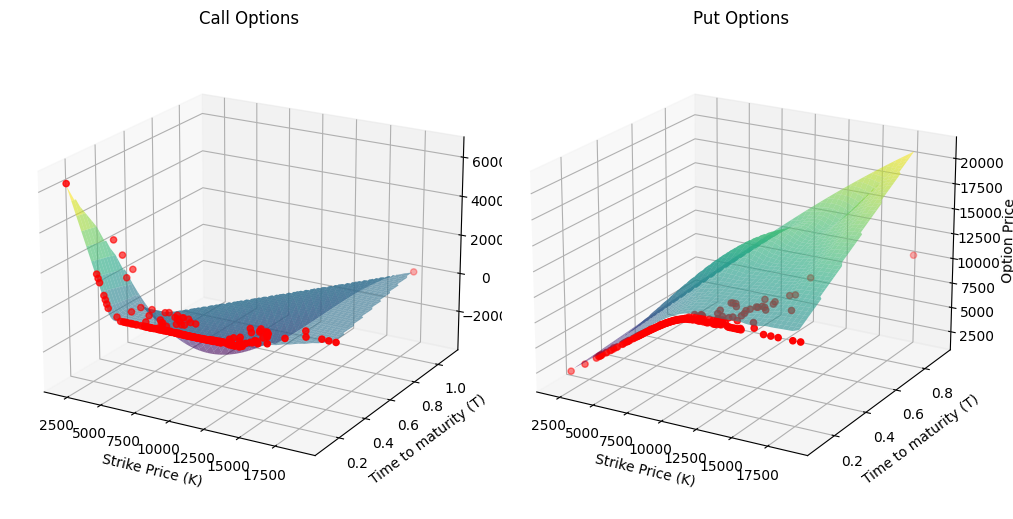

In [ ]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Read the data
file_path = 'BCC_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Read the data
file_path = 'BCC_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

#Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Extract relevant columns
result = options_data[['PUTCALLIND', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'OUTSIDE_THRESHOLD']]

print(result)

# Export the DataFrame to a CSV file
result.to_csv('BCC_SLSQP_with_errors.csv', index=False)


    PUTCALLIND  IMP_VOLT  PERCENTAGE_ERROR  OUTSIDE_THRESHOLD
1         CALL     23.23               NaN              False
2         CALL     23.23               NaN              False
3         CALL     23.25               NaN              False
4         CALL     23.26               NaN              False
5         CALL     23.32               NaN              False
..         ...       ...               ...                ...
373       CALL    115.42          9.466722               True
374       CALL    118.17         25.670988               True
375       CALL    130.77         15.825729               True
376       PUT     150.50          7.084663               True
377       CALL    203.25          1.552314              False

[377 rows x 4 columns]


In [ ]:
import numpy as np
import pandas as pd

# Read the data
file_path = 'BCC_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Replace 'inf' percentage error with None for CALL options
options_data.loc[(options_data['PUTCALLIND'] == 'CALL') & (options_data['PERCENTAGE_ERROR'] == np.inf), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Count the number of 'CALL' and 'PUT' options within the threshold
num_calls_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'CALL') & (options_data['OUTSIDE_THRESHOLD'] == False)])
num_puts_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'PUT ') & (options_data['OUTSIDE_THRESHOLD'] == False)])

print(f"Number of CALL options within threshold: {num_calls_within_threshold}")
print(f"Number of PUT options within threshold: {num_puts_within_threshold}")


Number of CALL options within threshold: 177
Number of PUT options within threshold: 38


In [ ]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'BCC_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()
